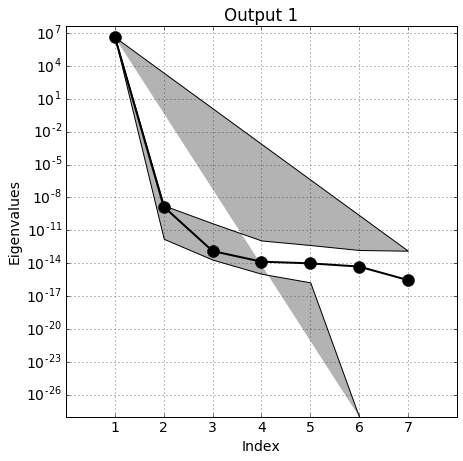

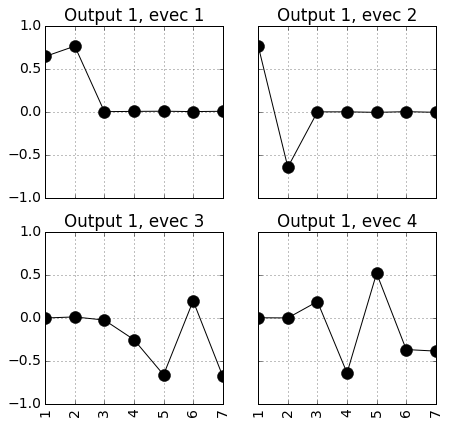

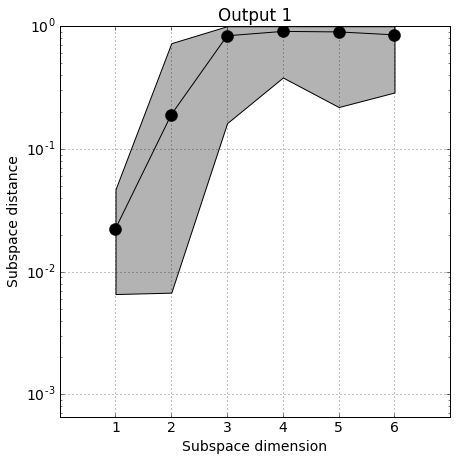

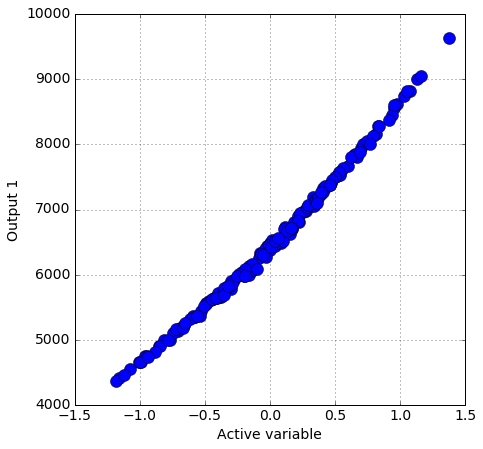

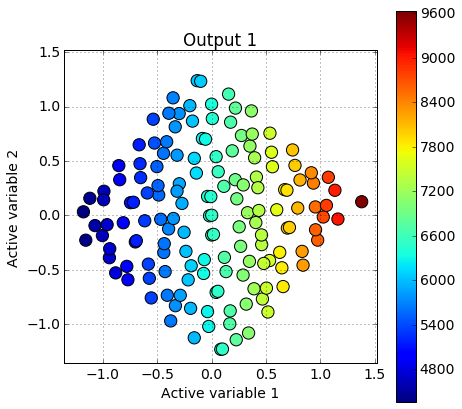

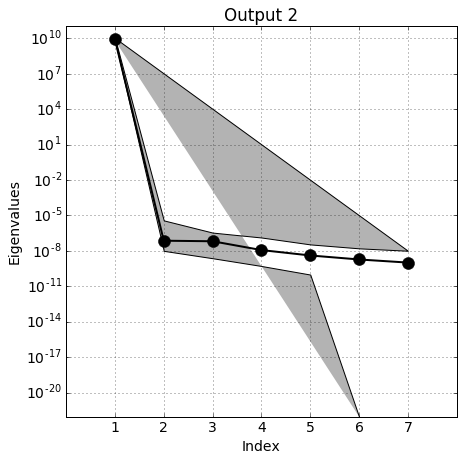

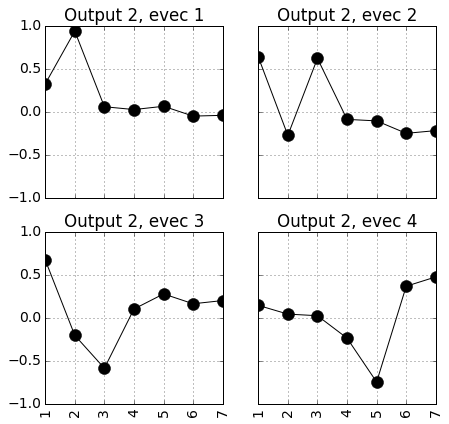

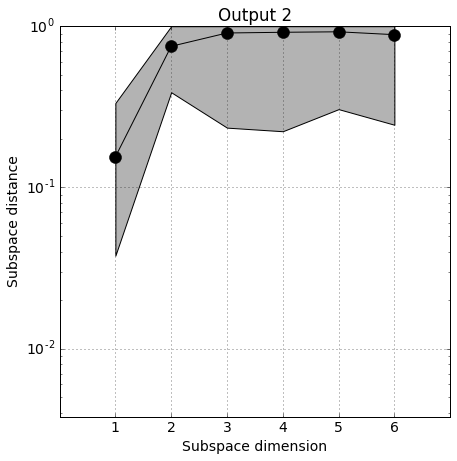

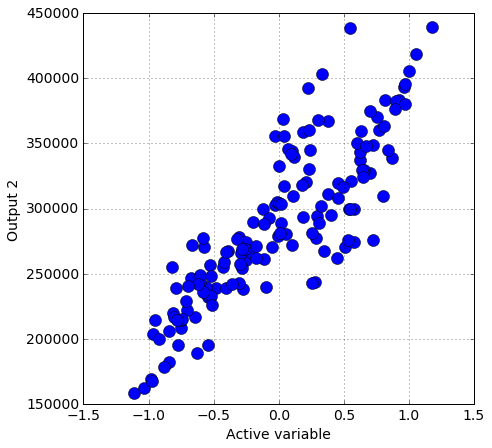

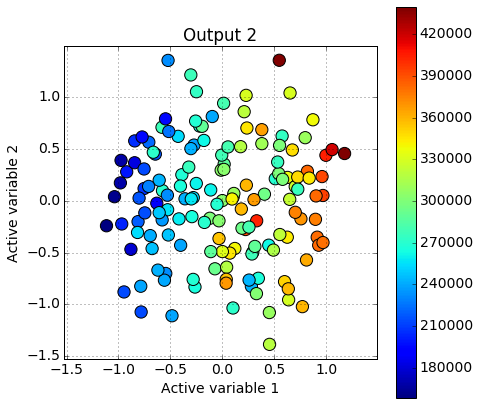

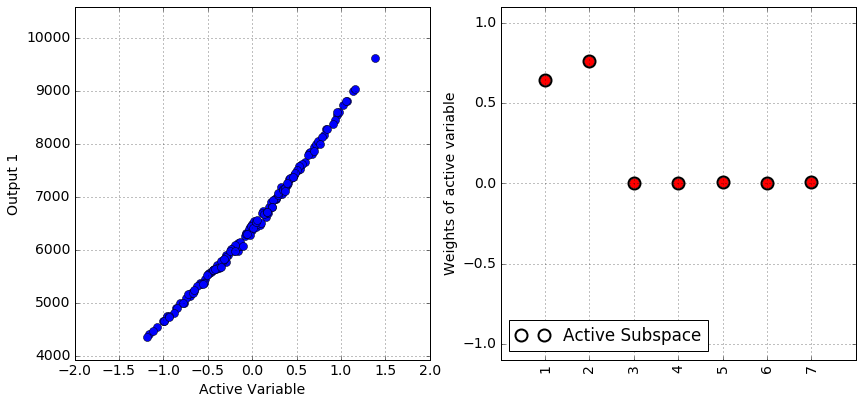

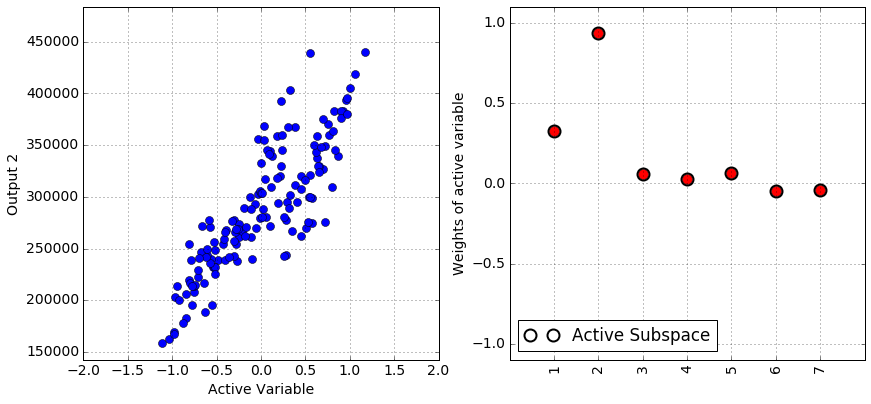

In [6]:
%matplotlib inline
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import active_subspaces as ac
from animate import *


#This is the code that needs to be altered on a case-by-case basis.
##################################################################

#These are the lower (xl) and upper (xu) limits of the inputs, for example:
#xl = np.array([2.6, 0.1, 122.5, 1.6448e7, 3.0551e6, 0.6*0.05, 0.6*0.145])

xl = np.array([16.3,13.7,0.001,-.36,-.3,-.3,-.3])
xu = np.array([24.3,17.3,0.002,.36,.3,.3,.3])

#These are the input and output label names: a list of strings. For example:
#in_labels = ['AoA', 'Turbulence', 'Length Scale', 'Pressure', 'Enthalpy', \
#'cowl transition', 'ramp transition']
#Leave empty if you'd like

in_labels = []
out_labels = []

#set sstype to 0 if df.txt is present; else set sstype to 5

sstype = 5

#set wrt_orig to True if gradients are with respect to the original variables,
#False if they are with respect to normalized variables. Either works if df is absent.

wrt_orig = False

##################################################################










#Read in data from their files
X = pn.DataFrame.from_csv('inputs.txt', header=None, index_col=None).as_matrix()
f = pn.DataFrame.from_csv('outputs.txt', header=None, index_col=None).as_matrix()
if sstype == 0: df = pn.DataFrame.from_csv('gradients.txt', header=None,\
                                           index_col=None).as_matrix()
else: df = None
        
M,m = X.shape

if not in_labels:
    for i in range(m): in_labels.append(str(i+1))
if not out_labels:
    for i in range(f.shape[1]): out_labels.append('Output {}'.format(i+1))
        
#Scale gradients according to the chain rule to be wih respect to normalized inputs
if wrt_orig and df is not None:
    for i in range(f.shape[1]): df[:,m*i:m*(i+1)] *= .5*(xu-xl).reshape((1, m))
        
#Normalize the data based on the limits above
XX = ac.utils.misc.BoundedNormalizer(xl, xu).normalize(X)


#make plots for for every output
for i in range(f.shape[1]):
    #Set up/compute the active subspace
    ss = ac.subspaces.Subspaces()
    if df is not None:
        ss.compute(X=XX, f=f[:,i][:,None], df=df[:,m*i:m*(i+1)], sstype=sstype, nboot=500)
    else: ss.compute(X=XX, f=f[:,i][:,None], sstype=sstype, nboot=500)

    #Plots
    ac.utils.plotters.eigenvalues(ss.eigenvalues, ss.e_br, out_labels[i])
    ac.utils.plotters.eigenvectors(ss.eigenvectors, None, in_labels, out_labels[i])
    ac.utils.plotters.subspace_errors(ss.sub_br, out_labels[i])
    ss.partition(2)
    y = XX.dot(ss.W1)
    ac.utils.plotters.sufficient_summary(y, f[:,i], out_labels[i])

#Animate if not more than 20-dimensional input space and no more than 3 outputs
if m <= 20 and f.shape[1] <= 3:
    for i in range(f.shape[1]):
        if df is not None:
            ss.compute(X=XX, f=f[:,i][:,None], df=df[:,m*i:m*(i+1)], sstype=sstype)
        else: ss.compute(X=XX, f=f[:,i][:,None], sstype=sstype)
        ss.partition(1)
        name = "animation_{}.mp4".format(i+1)
        br = 859*4 if m <= 10 else 859*2
        dpi = 200 if m <=10 else 150
        animate(XX, f[:,i], ss.W1, br, dpi, name, in_labels, out_labels[i])